In [1]:
import os
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib  as mpl
import matplotlib.pyplot as plt
import os, shutil, glob
import re, math
import seaborn as sns; sns.set(color_codes=False)

In [2]:
Colors = [ 'darkorange', 'cornflowerblue',
                'forestgreen', 'red', 'yellow']
Alpha = 0.5 
LineWidth = 0.5
yRange = [-5.5, 6] # range for ploting scaled data (in SD)
FigureSize = (10, 5)
Resolution = 300
FontSize = 9
Flags = []

### Select one or several input files or folders

In [3]:
BaseDir = 'Datasets'
sorted(os.listdir(BaseDir))

['.ipynb_checkpoints',
 'Features_5_percent_sample_Plate5.csv',
 'Features_images_MCR5_HCoV229_Plate5.csv',
 'Features_images_MRC5_HCoV229.csv',
 'qcRAW_images_MRC5_HCoV229_Plate1.csv',
 'qcRAW_images_MRC5_HCoV229_Plate2.csv',
 'qcRAW_images_MRC5_Plate3.csv',
 'qcRAW_images_MRC5_Plate4.csv']

In [4]:
InputFiles = []
NameContains = input("Enter part of name(s) of the file(s) of image quality data: ") # MRC5
for f in (f for f in os.listdir(BaseDir) if ((NameContains in f) & ('qcRAW_images' in f))):
    InputFiles.append(f)
print ('InputFiles: ' + str(InputFiles))
data =  pd.DataFrame()
ReadingFile = 0
for file in sorted(InputFiles):
    DataFromOneFile =  pd.read_csv(BaseDir + '/' + file, sep=",", low_memory=False)
    ReadingFile += 1
    data = data.append(DataFromOneFile.iloc[:,:], ignore_index=True)
print ('Dataframe contains %s columns and %s rows.' %(data.shape[1], data.shape[0]))

Enter part of name(s) of the file(s) of image quality data:  MRC5


InputFiles: ['qcRAW_images_MRC5_HCoV229_Plate1.csv', 'qcRAW_images_MRC5_Plate3.csv', 'qcRAW_images_MRC5_HCoV229_Plate2.csv', 'qcRAW_images_MRC5_Plate4.csv']
Dataframe contains 253 columns and 2160 rows.


In [5]:
try: 
    PlateNames = sorted(list(set(data['Metadata_Barcode'])))
    print('Number of plates: %s' %(len(PlateNames)))
    print(PlateNames)
    data.sort_values(['Metadata_Barcode','Metadata_Well', 'Metadata_Site'], inplace = True)
    data.reset_index(drop=True, inplace = True)
except:
    print('Plate names not specified')
    PlateNames = []
Wells = sorted(list(set(data['Metadata_Well'])))
NrOfWells = len(Wells)
print('Number of wells: %s' %(NrOfWells))
Rows = sorted(list(set([w[0] for w in Wells])))
print(*Rows)
NrOfRows = len(Rows)
Columns = sorted(list(set([w[1:] for w in Wells])))
NrOfColumns = len(Columns)
print(*Columns)
Sites = sorted(list(set(data['Metadata_Site'])))
NrOfSites = len(Sites)
print('Number of sites: %s' %(NrOfSites))

Number of plates: 4
['Exp4-MRC5-L4-229E-s', 'Exp4-MRC5-L4-no229E-s', 'Exp4-MRC5-L5-229E-s', 'Exp4-MRC5-L5-no229E-s']
Number of wells: 60
B C D E F G
02 03 04 05 06 07 08 09 10 11
Number of sites: 9


### Specify path for output

In [6]:
PathToPlots = input("Enter path for output: ") # ./QC_results/
if not os.path.exists(PathToPlots): 
    os.makedirs(PathToPlots)
PathToPlots

Enter path for output:  Results


'Results'

### Select measures

In [7]:
ImageQuality = [s for s in data.columns if "ImageQuality_" in s]
ImageQualityModule = [s.replace('ImageQuality_', '') for s in ImageQuality]
ImageQualityMeasures = sorted(list(set([re.sub('_.*', '', s) for s in ImageQualityModule])))
CountMeasures = len(ImageQualityMeasures)
print('ImageQuality module has measured '
      + str(CountMeasures) + ' parameters: ' + ', '.join(ImageQualityMeasures))

ImageQuality module has measured 22 parameters: Correlation, FocusScore, LocalFocusScore, MADIntensity, MaxIntensity, MeanIntensity, MedianIntensity, MinIntensity, PercentMaximal, PercentMinimal, PowerLogLogSlope, Scaling, StdIntensity, ThresholdBackground, ThresholdKapur, ThresholdMCT, ThresholdMoG, ThresholdOtsu, ThresholdRidlerCalvard, ThresholdRobustBackground, TotalArea, TotalIntensity


In [8]:
NotSoUseful = ['TotalArea', 'Scaling', 'TotalIntensity', 'Correlation', 'PercentMinimal'
               ,'LocalFocusScore', 'MinIntensity', 'MedianIntensity', 'MADIntensity'
               ,'ThresholdMoG'
               ,'ThresholdBackground'
               ,'ThresholdKapur'
               ,'ThresholdMCT'
               ,'ThresholdOtsu'
               ,'ThresholdRidlerCalvard'
               ,'ThresholdRobustBackground'                      
               ]
for u in NotSoUseful:
    ImageQualityMeasures.remove(u)
CountMeasures = len(ImageQualityMeasures)
print('This notebook will use '+ str(CountMeasures) + ' measures: ' + 
      ', '.join(ImageQualityMeasures))

DataFrameDictionary = {}
for z in ImageQualityMeasures:
    parameter = [s for s in ImageQuality if ('_' + z) in s]
    DataFrameDictionary[z]=data[parameter]
DataFrameList = sorted(list(DataFrameDictionary.keys()))

This notebook will use 6 measures: FocusScore, MaxIntensity, MeanIntensity, PercentMaximal, PowerLogLogSlope, StdIntensity


### Create lineplots

In [9]:
nrSubplots=len(DataFrameList)
# old: ChannelNames = [ 'Hoechst', 'Mito', 'Phalloid.', 'Syto', 'Concan.']
# new:
ChannelNames = []
for c in list(DataFrameDictionary[DataFrameList[0]].columns):
    ChannelNames.append(re.sub('.*_', '', c))
ChannelNames

['CONC', 'HOECHST', 'MITO', 'PHAandWGA', 'SYTO']

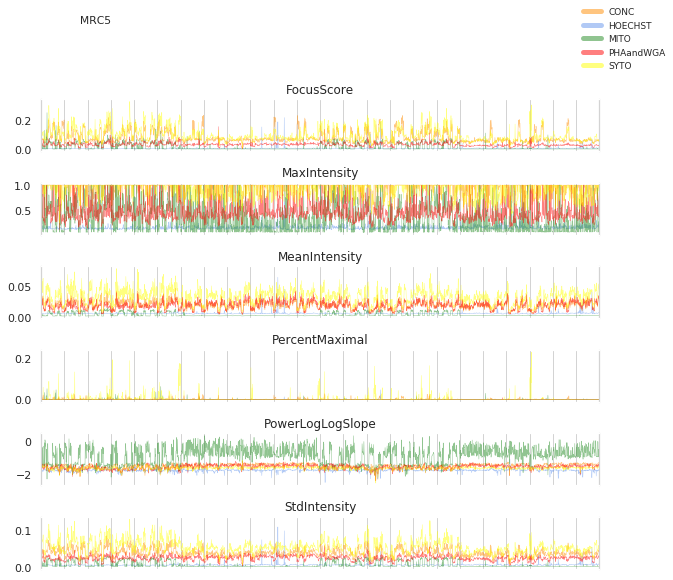

In [10]:
fig = plt.figure(figsize = (FigureSize[0],1.5*nrSubplots))
fig.suptitle(NameContains,fontsize = FontSize*1.2, x = 0.2)

for x in range(0, nrSubplots):
    CurrentDataFrame = DataFrameDictionary.get(DataFrameList[x])
    CurrentDFName = ImageQualityMeasures[x]
    #print(CurrentDataFrame.columns)

    ax = fig.add_subplot(nrSubplots, 1, x+1)
    ax.set_title(CurrentDFName, fontsize = 12)
    ax.set_facecolor('w')
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['left'].set_color('lightgrey')
    ax.spines['right'].set_color('lightgrey')
    ax.set_xlim([0, len(CurrentDataFrame.index)])
    #ax.set_ylim([0, 1])
    myplot = CurrentDataFrame.plot(kind='line', linewidth=0.5, alpha=Alpha, ax=ax, legend=None, color = Colors)
    xticks = np.arange(0, len(CurrentDataFrame.index), NrOfSites*NrOfColumns)
    ax.set_xticks(xticks)
    # ax.set_yticks()
    ax.grid(b=True, which='major', axis='x', color='lightgrey', linestyle='-', linewidth=1, alpha = 1)
    ax.grid(b=True, which='major', axis='y', color='lightgrey', linestyle='', linewidth=0)
    ax.tick_params(axis='x', labelbottom=False)
plt.subplots_adjust(top=0.85, hspace=0.60)
leg = fig.legend(ChannelNames, fontsize = FontSize, frameon=False)
for line in leg.get_lines():
    line.set_linewidth(5.0)
plt.savefig('{}/Unscaled.png'.format(PathToPlots), dpi=Resolution)
plt.show()

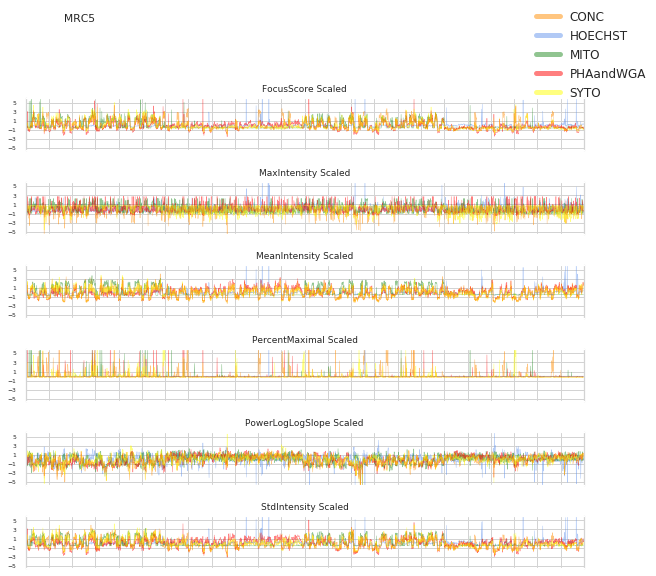

In [11]:
fig = plt.figure(figsize = (FigureSize[0],1.5*nrSubplots))
fig.suptitle(NameContains,fontsize = FontSize*1.2, x = 0.2)
for x in range(0, nrSubplots):
    CurrentDataFrame = DataFrameDictionary.get(DataFrameList[x])
    CurrentDFName = ImageQualityMeasures[x]
    x_unscaled = CurrentDataFrame.values #returns a numpy array
    x_scaled = StandardScaler().fit_transform(x_unscaled)
    CurrentDataFrameScaled = pd.DataFrame(x_scaled, columns = ChannelNames)

    ax = fig.add_subplot(nrSubplots, 1, x+1)
    ax.set_title(CurrentDFName + ' Scaled', fontsize = FontSize)
    ax.set_facecolor('w')
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['left'].set_color('lightgrey')
    ax.spines['right'].set_color('lightgrey')
    ax.set_xlim([0, len(CurrentDataFrame.index)])
    ax.set_ylim(yRange[0], yRange[1])
    myplot = CurrentDataFrameScaled.plot(kind='line', linewidth=0.5, alpha=0.5, ax=ax, legend=None, color = Colors)
    xticks = np.arange(0, len(CurrentDataFrame.index), NrOfSites*NrOfColumns)
    ax.set_xticks(xticks)
    ax.set_yticks(np.arange(start = math.ceil(yRange[0]), stop = yRange[1], step = 2))
    ax.grid(b=True, which='major', axis='x', color='lightgrey', linestyle='-', linewidth=1, alpha = 1)
    ax.grid(b=True, which='major', axis='y', color='lightgrey', linestyle='-', linewidth=1, alpha = 1)
    ax.tick_params(axis='x', labelbottom=False)
    for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(6)
plt.subplots_adjust(top=0.85, hspace=0.60)
leg = fig.legend(ChannelNames, fontsize = 12, frameon=False)
for line in leg.get_lines():
    line.set_linewidth(5.0)
plt.savefig('{}/Scaled.png'.format(PathToPlots), dpi=Resolution)
plt.show()

### Create flags for PowerLogLogSlope (> -2.3)

In [12]:
for i, item in enumerate(DataFrameList):
        print(i, item)

p = input('Enter an integer from 0 to %s:' %(len(DataFrameList)-1))
try:
    p = int(p)
except:
    p=0
CurrentDataFrame = DataFrameDictionary.get(DataFrameList[p])
CurrentDFName = ImageQualityMeasures[p]
CurrentDataFrame.describe(percentiles =  [.25, .5, .75, .90, .99]).iloc[1:]

0 FocusScore
1 MaxIntensity
2 MeanIntensity
3 PercentMaximal
4 PowerLogLogSlope
5 StdIntensity


Enter an integer from 0 to 5: 4


,ImageQuality_PowerLogLogSlope_CONC,ImageQuality_PowerLogLogSlope_HOECHST,ImageQuality_PowerLogLogSlope_MITO,ImageQuality_PowerLogLogSlope_PHAandWGA,ImageQuality_PowerLogLogSlope_SYTO
mean,-1.497832,-1.762482,-0.851776,-1.572901,-1.645881
std,0.133194,0.086408,0.498939,0.134769,0.089238
min,-2.388358,-2.517254,-2.309010,-2.426146,-2.557033
25%,-1.580039,-1.795412,-1.340662,-1.664044,-1.693159
50%,-1.469678,-1.763668,-0.838514,-1.561281,-1.636165
75%,-1.401994,-1.721945,-0.476088,-1.474802,-1.590136
90%,-1.354386,-1.670625,-0.164778,-1.411761,-1.550338
99%,-1.293266,-1.556835,0.111670,-1.317749,-1.465951
max,-1.253700,-1.094661,0.359764,-1.216165,-1.142616


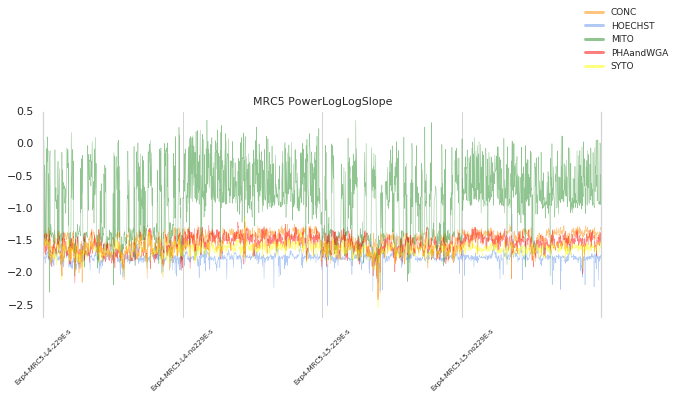

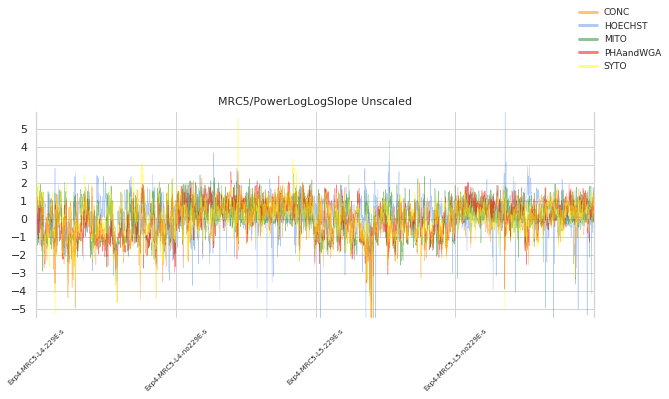

In [13]:
# PLOT RAW DATA

fig = plt.figure(figsize = FigureSize)
ax = fig.add_subplot(111)
ax.set_title(NameContains + ' ' + CurrentDFName, fontsize = FontSize + 2)
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('lightgrey')
ax.spines['right'].set_color('lightgrey')
ax.set_xlim([0, len(CurrentDataFrame.index)])
ax.set_facecolor('w')
myplot = CurrentDataFrame.plot(kind='line', linewidth=LineWidth, alpha=Alpha, ax=ax, legend=None, color = Colors)
xticks = np.arange(0, len(CurrentDataFrame.index), NrOfSites*NrOfColumns*NrOfRows)
ax.set_xticks(xticks)
ax.set_xticklabels(PlateNames)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FontSize -2) 
    tick.label.set_rotation(45)
ax.grid(b=True, which='major', axis='x', color='lightgrey', linestyle='-', linewidth=1, alpha = 1)
ax.grid(b=True, which='major', axis='y', color='lightgrey', linestyle='', linewidth=0)
ax.tick_params(axis='x', labelbottom=True, color='lightgrey')
plt.subplots_adjust(top=0.7, hspace=0.40)
leg = fig.legend(ChannelNames, fontsize = FontSize,frameon=False)
for line in leg.get_lines():
    line.set_linewidth(3.0)
plt.savefig(PathToPlots + '/' +CurrentDFName + 'Unscaled.png', dpi = Resolution)
plt.show()

# PLOT SCALED DATA
x_unscaled = CurrentDataFrame.values 
x_scaled = StandardScaler().fit_transform(x_unscaled)
CurrentDataFrameScaled = pd.DataFrame(x_scaled, columns = ChannelNames)

fig = plt.figure(figsize = FigureSize)
ax = fig.add_subplot(111)
ax.set_title(NameContains + '/' + CurrentDFName + ' Unscaled', fontsize = FontSize + 2)
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('lightgrey')
ax.spines['right'].set_color('lightgrey')
ax.set_xlim([0, len(CurrentDataFrame.index)])
ax.set_facecolor('w')

myplot = CurrentDataFrameScaled.plot(kind='line', linewidth=LineWidth, alpha=Alpha, ax=ax, legend=None, color = Colors)
xticks = np.arange(0, len(CurrentDataFrame.index), NrOfSites*NrOfColumns*NrOfRows)
ax.set_xticks(xticks)
ax.set_xticklabels(PlateNames)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FontSize -2) 
    tick.label.set_rotation(45)
ax.set_ylim(yRange)
ax.set_yticks(np.arange(start = math.ceil(yRange[0]), stop = yRange[1]))
ax.grid(b=True, which='major', axis='x', color='lightgrey', linestyle='-', linewidth=1, alpha = 1)
ax.grid(b=True, which='major', axis='y', color='lightgrey', linestyle='-', linewidth=1, alpha = 1)
ax.tick_params(axis='x', labelbottom=True, color='lightgrey')
plt.subplots_adjust(top=0.7, hspace=0.40)
leg = fig.legend(ChannelNames, fontsize = FontSize,frameon=False)
for line in leg.get_lines():
    line.set_linewidth(3.0)
plt.savefig(PathToPlots + '/' + CurrentDFName + 'Scaled.png', dpi=Resolution)
plt.show() 

In [14]:
LowerLimit = -2.3 
UpperLimit = float('inf')
NewFlagRaw = 'Outlier' + '_' + DataFrameList[p] + '_' + str(LowerLimit) + '_' + str (UpperLimit)
Flags.append(NewFlagRaw)
print('Outliers will be flagged in column: ' + NewFlagRaw)
data[NewFlagRaw] = 0

Outliers will be flagged in column: Outlier_PowerLogLogSlope_-2.3_inf


In [15]:
CurrentDataFrameOutliersMetadata = data[(CurrentDataFrame.values > UpperLimit).
                                any(1) | (CurrentDataFrame.values < LowerLimit).
                                        any(1)][['Metadata_Barcode', 'Metadata_Well', 'Metadata_Site']]
CurrentDataFrameOutliersValues = CurrentDataFrame[(CurrentDataFrame.values > UpperLimit).
                                any(1) | (CurrentDataFrame.values < LowerLimit).
                                any(1)]
CurrentDataFrameOutliers = CurrentDataFrameOutliersMetadata.merge(CurrentDataFrameOutliersValues,
                                                                  left_index=True, right_index=True)
print('%s images flagged in column %s' %(CurrentDataFrameOutliers.shape[0], NewFlagRaw))
CurrentDataFrameOutliers

4 images flagged in column Outlier_PowerLogLogSlope_-2.3_inf


,Metadata_Barcode,Metadata_Well,Metadata_Site,ImageQuality_PowerLogLogSlope_CONC,ImageQuality_PowerLogLogSlope_HOECHST,ImageQuality_PowerLogLogSlope_MITO,ImageQuality_PowerLogLogSlope_PHAandWGA,ImageQuality_PowerLogLogSlope_SYTO
23,Exp4-MRC5-L4-229E-s,B04,6,-1.352569,-1.757494,-2.309010,-1.621414,-1.570186
1099,Exp4-MRC5-L5-229E-s,B04,2,-1.537127,-2.517254,-1.614771,-1.579024,-1.845589
1295,Exp4-MRC5-L5-229E-s,D05,9,-2.388358,-2.157117,-1.739511,-2.426146,-2.557033
1303,Exp4-MRC5-L5-229E-s,D06,8,-2.332661,-2.293066,-1.638920,-2.002897,-2.230497


In [16]:
Outliers = CurrentDataFrameOutliers.index.values.tolist()
data.loc[Outliers,NewFlagRaw] = 1
print('%s images flagged in column %s' %(CurrentDataFrameOutliers.shape[0], NewFlagRaw))

4 images flagged in column Outlier_PowerLogLogSlope_-2.3_inf


### Create flags for images deviating more than 5 SD

In [17]:
LowerLimitScaled = -5 #float('-inf')
UpperLimitScaled = 5 #float('inf')

In [18]:
for p in range(0, len(DataFrameList)):
    CurrentDataFrame = DataFrameDictionary.get(DataFrameList[p])
    CurrentDFName = ImageQualityMeasures[p]
    
    x_unscaled = CurrentDataFrame.values 
    x_scaled = StandardScaler().fit_transform(x_unscaled)
    CurrentDataFrameScaled = pd.DataFrame(x_scaled, columns = ChannelNames)

    NewFlagSc = 'OutlierScaled' + '_' + DataFrameList[p] + '_' + str(LowerLimitScaled) + '_' + str (UpperLimitScaled)
    Flags.append(NewFlagSc)
    data[NewFlagSc] = 0

    CurrentDataFrameOutliersMetadata = data[(CurrentDataFrameScaled.values >= UpperLimitScaled).
                                    any(1) | (CurrentDataFrameScaled.values <= LowerLimitScaled).
                                    any(1)][['Metadata_Barcode', 'Metadata_Well', 'Metadata_Site']]
    CurrentDataFrameOutliersValues = CurrentDataFrameScaled[(CurrentDataFrameScaled.values >= UpperLimitScaled).
                                    any(1) | (CurrentDataFrameScaled.values <= LowerLimitScaled).
                                    any(1)]
    CurrentDataFrameScaledOutliers = CurrentDataFrameOutliersMetadata.merge(CurrentDataFrameOutliersValues,
                                                                      left_index=True, right_index=True)

    Outliers = CurrentDataFrameScaledOutliers.index.values.tolist()
    data.loc[Outliers,NewFlagSc] = 1

In [19]:
data['Total'] = data[Flags].max(axis = 1)
Flags.append('Total')
print(data[Flags].sum())

data.to_csv(PathToPlots + '/Flagged.csv', sep = ';')
print('\n{} images flagged in file {}Flagged.csv'.format(data.Total.sum(), PathToPlots))

Outlier_PowerLogLogSlope_-2.3_inf       4
OutlierScaled_FocusScore_-5_5          22
OutlierScaled_MaxIntensity_-5_5        10
OutlierScaled_MeanIntensity_-5_5        8
OutlierScaled_PercentMaximal_-5_5      76
OutlierScaled_PowerLogLogSlope_-5_5    13
OutlierScaled_StdIntensity_-5_5        11
Total                                  95
dtype: int64

95 images flagged in file ResultsFlagged.csv
